# 0. Load pickled result files

In [1]:
from glob import glob
from pickle import load
from scipy.stats import norm
import matplotlib.pyplot as plt
from simtk import unit
import numpy as np
%matplotlib inline

#pkls = glob('../data/estimator_comparison/*.pkl')
#pkls = glob('../data/water_cluster_flexible/*.pkl')
pkls = glob('../data/water_cluster_rigid/*.pkl')
#pkls = glob('../data/water_cluster_rigid_2/*.pkl')

In [2]:
len(pkls), len(pkls) / 136

(125, 0.9191176470588235)

In [3]:
summary = []

def extract_result(result):
    return result[1]['near_eq_estimate'], result[1]['new_estimate']

for fname in pkls:
    with open(fname, 'rb') as f:
        result = load(f)
    summary.append((result[0], extract_result(result)))

In [4]:
results = []
for fname in pkls:
    with open(fname, 'rb') as f:
        results.append(load(f))

In [5]:
dts = sorted(list(set([r[0][1].value_in_unit(unit.femtosecond) for r in results])))
dts

[0.10000000000000001,
 0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0,
 4.5,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0]

# 1. Examine work distributions

In [6]:
# assign a colormap to each scheme, so increasing dt progresses along that colormap

import seaborn.apionly as sns
schemes = sorted(['RVOVR', 'VRORV', 'OVRVO', 'ORVRO'])
colors = dict(zip(schemes, ['Blues', 'Greens', 'Oranges', 'Purples']))

colormaps = dict()

for scheme in schemes:
    colormap = sns.color_palette(colors[scheme], n_colors=len(dts))
    colormaps[scheme] = dict(zip(dts, colormap))

In [7]:
dt_ = max(dts)
full_depth_colors = dict()
for scheme in schemes:
    full_depth_colors[scheme] = colormaps[scheme][dt_]
    
    
dt_ = sorted(dts)[int(len(dts) / 2)]
half_depth_colors = dict()
for scheme in schemes:
    half_depth_colors[scheme] = colormaps[scheme][dt_]

In [8]:
def remove_nans(array):
    return array[np.isfinite(array)]

In [9]:
remove_nans(results[-1][-1]['Ws'].flatten())

array([ 0.03651414, -0.01834182, -0.00577383, ...,  0.00405354,
       -0.03196801,  0.05771644])

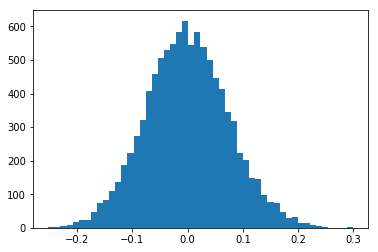

In [10]:
plt.hist(remove_nans(results[-1][-1]['Ws'].flatten()), bins=50);

In [11]:
def remove_nans(array):
    return array[np.isfinite(array)]

def get_work_distributions(scheme='RVOVR', marginal='configuration'):
    flat_Ws = []
    
    dts = []
    
    # get dt and a collection of work measurements for each 
    for summary, result in results:
        if summary[0] == scheme and summary[2] == marginal:
            flat_Ws.append(remove_nans(np.hstack(result['Ws'])))
            dts.append(summary[1].value_in_unit(unit.femtosecond))
    
    
    # sort everything by dt
    inds = np.argsort(dts)
    dts = np.array(dts)[inds]
    flat_Ws = [flat_Ws[i] for i in inds]
    
    return dts, flat_Ws
    

def plot_work_distributions(scheme='RVOVR', marginal='configuration', log=True, importance=False):
    
    dts, flat_Ws = get_work_distributions(scheme, marginal)
    
    n_to_skip = 2
    
    for (dt, Ws) in zip(dts[n_to_skip:], flat_Ws[n_to_skip:]):
        color = colormaps[scheme][dt]
        
        # get (density, bin_edges) then plot on midpoints
        y,x_ = np.histogram(Ws, density=True, bins='auto')
        x = (x_[1:] + x_[:-1]) / 2
        
        #plt.plot(x, y, '.', alpha=dt / 4, linewidth=1.0, color=color)
        plt.scatter(x, y, s=2.0, alpha=1.0, color=color)

        
        # also plot (log-)density of gaussian approximation?
        mu, sigma = np.mean(Ws), np.std(Ws)
        normal = norm(loc=mu, scale=sigma)
        
        n_sigma = 4
        x_grid = np.linspace(mu - n_sigma * sigma, mu + n_sigma * sigma, num=100)
        y_grid = normal.pdf(x_grid)
        plt.plot(x_grid, y_grid, linewidth=1.0, alpha=1.0, color=color, label=dt)
        plt.fill_between(x_grid, y_grid, alpha=0.1, color=color)
        
    if importance:
        # plot the e^{-w} importance weight?
        x_min = min([min(Ws) for Ws in flat_Ws])
        x_max = max([max(Ws) for Ws in flat_Ws])
        x_grid = np.linspace(x_min, x_max)
        y_grid = np.exp(-x_grid)
        plt.plot(x_grid, y_grid, '--', color='grey')
        
    plt.legend(title=r'$\Delta t$ (fs)', loc='best')
    
    plt.xlabel(r'work ($k_B T$)')
    
    ylabel = 'probability'
    if log:
        plt.yscale('log')
        ylabel = 'log-' + ylabel
    plt.ylabel(ylabel)
    plt.title('{}'.format(scheme))


def make_multi_panel_plot(marginal='configuration', log=True):
    plt.figure(figsize=(8,8))
    
    for i in range(len(schemes)):
        if i == 0:
            ax = plt.subplot(2,2,i+1)
        else:
            ax = plt.subplot(2,2,i+1, sharey=ax, sharex=ax)
        
        plot_work_distributions(schemes[i], marginal, log=log)
        
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    
    plt.tight_layout()

    plt.savefig('work_distributions_water_cluster_{}.jpg'.format(marginal), dpi=300)

In [12]:
colors[schemes[0]]

'Blues'

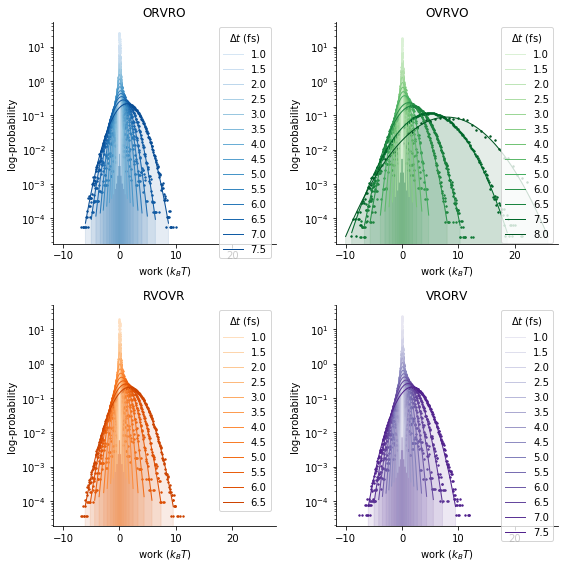

In [13]:
make_multi_panel_plot('configuration')

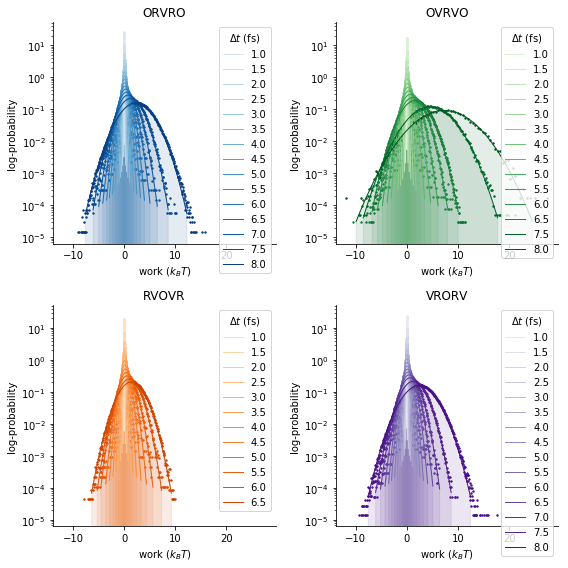

In [14]:
make_multi_panel_plot('full')

# 2. Plot standard deviation of work distribution as function of stepsize

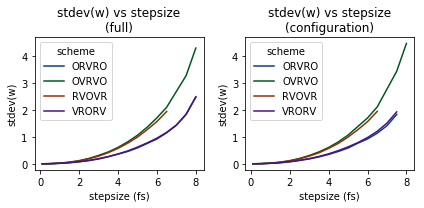

In [15]:
def plot_work_variances(marginal='full'):
    for scheme in schemes:
        dts, flat_Ws = get_work_distributions(scheme, marginal=marginal)
        plt.plot(dts, [np.std(Ws) for Ws in flat_Ws], label=scheme, color=full_depth_colors[scheme])

    plt.legend(title='scheme', loc='best')
    plt.title('stdev(w) vs stepsize\n({})'.format(marginal))
    plt.xlabel('stepsize (fs)')
    plt.ylabel('stdev(w)')
    
plt.figure(figsize=(6,3))
ax = plt.subplot(1,2,1)
plot_work_variances('full')
plt.subplot(1,2,2, sharey=ax)
plot_work_variances('configuration')

plt.tight_layout()
plt.savefig('w_stdev_wc.jpg', dpi=300)

# 3. Plot mismatch between $p(w)$ and $e^{-w} \cdot p(w)$

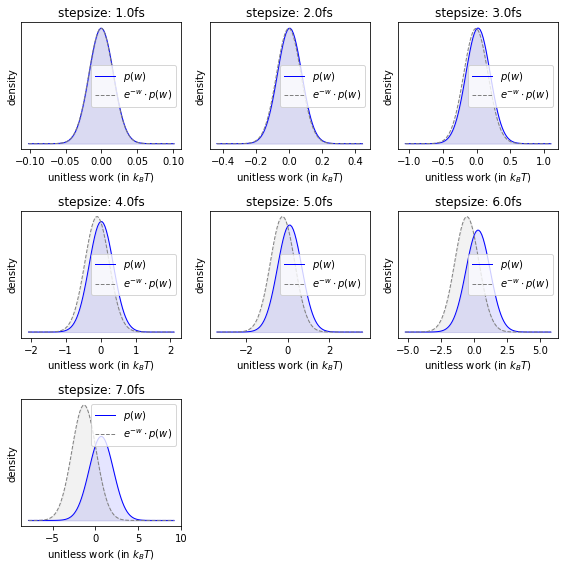

In [16]:
marginal = 'configuration'
scheme = schemes[0]
dts, flat_Ws = get_work_distributions(scheme, marginal=marginal)

n_skip=2

plt.figure(figsize=(8,8))
i = 1
for (dt, Ws) in zip(dts[n_skip:][::2], flat_Ws[n_skip:][::2]):
    plt.subplot(3,3,i)
    mu, sigma = np.mean(Ws), np.std(Ws)
    normal = norm(loc=mu, scale=sigma)

    n_sigma = 6
    x_grid = np.linspace(mu - n_sigma * sigma, mu + n_sigma * sigma, num=100)
    
    y_grid = normal.pdf(x_grid)
    plt.plot(x_grid, y_grid, linewidth=1.0, label=r'$p(w)$', color='blue', )
    plt.fill_between(x_grid, y_grid, linewidth=1.0, color='blue', alpha=0.1)
    
    y_grid = np.exp(normal.logpdf(x_grid) - x_grid)
    plt.plot(x_grid, y_grid, '--', linewidth=1.0, label=r'$e^{-w} \cdot p(w) $', color='grey')
    plt.fill_between(x_grid, y_grid, linewidth=1.0, color='grey', alpha=0.1)
    
    
    
    
    
    #plt.plot(dts, [np.std(Ws)**2 for Ws in flat_Ws], label=scheme)
#plt.yscale('log')
    plt.legend(loc='best')
    plt.xlabel(r'unitless work (in $k_B T$)')
    plt.yticks([])
    plt.ylabel('density')
    plt.title('stepsize: {}fs'.format(dt))
    
    i += 1
    
plt.tight_layout()
plt.savefig('p(w)-vs-exp(-w)p(w)_wc.jpg', bbox_inches='tight', dpi=300)

# 4. Plot near-equilibrium vs. "exact" estimates

In [17]:
def get_curves(scheme='RVOVR', marginal='configuration'):
    dts = []
    
    near_eq_estimates = []
    near_eq_unc = []
    
    new_estimates = []
    new_estimates_unc = []
    
    for (descr, (near_eq_est, new_est)) in summary:
        if descr[0] == scheme and descr[2] == marginal:
            dts.append(descr[1].value_in_unit(unit.femtosecond))
            near_eq_estimates.append(near_eq_est)
            new_estimates.append(new_est)
            
            
    
    
    inds = np.argsort(dts)
    sort_by_dt = lambda l : np.array(l)[inds]
    return list(map(sort_by_dt, [dts, near_eq_estimates, new_estimates]))

In [18]:
from benchmark.evaluation.compare_near_eq_and_exact import resample_Ws, process_outer_samples, estimate_from_work_samples
from tqdm import tqdm
n_bootstrap_samples = 100

means_new, stdevs_new = [], []


for result in tqdm(results):
    Ws = result[1]['Ws']
    samples_new = []
    #samples_near_eq = []
    
    for _ in range(n_bootstrap_samples):
        Ws_ = resample_Ws(Ws)
        new_estimate = np.mean([estimate_from_work_samples(w) for w in Ws_])
        
        samples_new.append(new_estimate)
        
    means_new.append(np.mean(samples_new))
    stdevs_new.append(np.std(samples_new))

means_new = np.array(means_new)
stdevs_new = np.array(stdevs_new)

/Users/joshuafass/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


OpenMM version:  7.2.0.dev-fb607c7
OpenMM version:  7.2.0.dev-fb607c7
	Removing CMMotionRemover
	Removing CMMotionRemover
Desired platform not supported
Desired platform not supported
Desired platform not supported
Desired platform not supported
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported


100%|██████████| 125/125 [00:59<00:00,  2.78it/s]


In [19]:
from benchmark.evaluation import estimate_nonequilibrium_free_energy

In [20]:
# okay and a summary of the uncertainties in the near-eq estimates too


means_near_eq, stdevs_near_eq = [], []


for result in tqdm(results):
    W_F = result[1]["W_shad_forward"]
    Ws = result[1]['Ws']
    samples_near_eq = []
    
    
    #mean, var = estimate_nonequilibrium_free_energy(W_F, W_R)
    #stdev = np.sqrt(var)
    
    for _ in range(n_bootstrap_samples):
        W_F_ = W_F[np.random.randint(0, len(W_F), len(W_F))]
        Ws_ = resample_Ws(Ws)
        
        near_eq_estimate = 0.5 * (np.mean(W_F_) - np.mean([np.mean(w) for w in Ws_]))
        samples_near_eq.append(near_eq_estimate)
    
    means_near_eq.append(np.mean(samples_near_eq))
    stdevs_near_eq.append(np.std(samples_near_eq))
    #means_near_eq.append(mean)
    #stdevs_near_eq.append(stdev)

means_near_eq = np.array(means_near_eq)
stdevs_near_eq = np.array(stdevs_near_eq)

100%|██████████| 125/125 [00:40<00:00,  3.96it/s]


In [21]:
def get_curves_with_unc(scheme='RVOVR', marginal='configuration'):
    dts = []
    
    near_eq_estimates = []
    near_eq_unc = []
    
    new_estimates = []
    new_estimates_unc = []
    
    for i, (descr, (near_eq_est, new_est)) in enumerate(summary):
        if descr[0] == scheme and descr[2] == marginal:
            dts.append(descr[1].value_in_unit(unit.femtosecond))
            
            near_eq_estimates.append(near_eq_est)
            new_estimates.append(new_est)
            
            near_eq_unc.append(stdevs_near_eq[i])
            new_estimates_unc.append(stdevs_new[i])
    
    inds = np.argsort(dts)
    sort_by_dt = lambda l : np.array(l)[inds]
    return list(map(sort_by_dt, [dts, near_eq_estimates, near_eq_unc, new_estimates, new_estimates_unc]))

In [22]:
from pickle import load

with open('result_summary.pkl', 'rb') as f:
    near_eq_result_summary = load(f)
    
def get_near_eq_curves_with_unc(scheme, marginal):
    r = near_eq_result_summary[scheme][marginal]
    return r['dts'], r['near_eq_estimates'], r['near_eq_uncertainty']

In [23]:
near_eq_result_summary['RVOVR']['configuration'].keys()

dict_keys(['dts', 'near_eq_estimates', 'near_eq_uncertainty'])

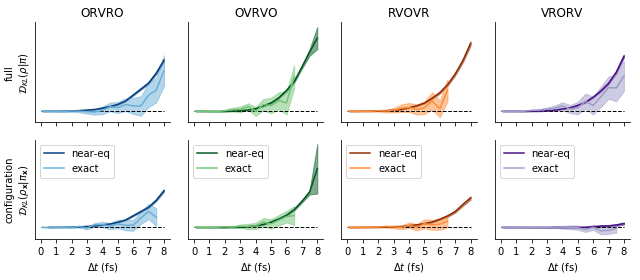

In [26]:
def new_figure():
    plt.figure(figsize=(8,8))

    
def remove_upper_right_spines(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
def plot_marginal(marginal='configuration', start_subplot=1, use_near_eq_summary=True):
        
    for i, scheme in enumerate(schemes):
        near_eq_color = full_depth_colors[scheme]
        exact_color = half_depth_colors[scheme]
        
        dts, near_eq_estimates, near_eq_unc, new_estimates, new_estimates_unc = get_curves_with_unc(scheme, marginal)
        dts_near_eq = dts
    
        
        if i == 0:
            ax_0 = plt.subplot(2,4,i+start_subplot)
            remove_upper_right_spines(ax_0)
        else:
            ax = plt.subplot(2,4,i+start_subplot,sharey=ax_0, sharex=ax_0)
            remove_upper_right_spines(ax)
        
        plt.title(scheme)
        
        if use_near_eq_summary:
            dts_near_eq, near_eq_estimates, near_eq_unc = get_near_eq_curves_with_unc(scheme, marginal)
        
        plt.plot(dts_near_eq, near_eq_estimates, color=near_eq_color, label='near-eq')
        plt.fill_between(dts_near_eq, near_eq_estimates - 1.96 * near_eq_unc, near_eq_estimates + 1.96 * near_eq_unc, color=near_eq_color, alpha=0.5)
        
        plt.plot(dts, new_estimates, color=exact_color, label='exact')
        plt.fill_between(dts, new_estimates - 1.96 * new_estimates_unc, new_estimates + 1.96 * new_estimates_unc, color=exact_color, alpha=0.5)
        
        
        if marginal == 'configuration':
            plt.ylabel('configuration\n' + r'$\mathcal{D}_{KL}(\rho_\mathbf{x} \| \pi_\mathbf{x})$')
        else:
            plt.ylabel('full\n' +r'$\mathcal{D}_{KL}(\rho \| \pi)$')
        
        xticks = list(range(0,1 + int(max(max(dts), max(dts_near_eq)))))
        
        if start_subplot == 5:
            plt.xticks(xticks)
            plt.xlabel(r'$\Delta t$ (fs)')
            plt.title('')
        else:
            plt.xticks(xticks, ['']*len(xticks))
            
        plt.hlines(0, 0, max(xticks), linewidths=1, linestyles='--', colors='k')
        
        if i  > 0:
            plt.ylabel('')
            plt.yticks([])
        
        if start_subplot == 5:
            plt.legend(loc='upper left')

        
plt.figure(figsize=(9,4))
plot_marginal('full')
plot_marginal('configuration', start_subplot=5)

plt.tight_layout()
plt.savefig('key_comparison_figure_draft.jpg', dpi=300, bbox_inches='tight')